# Mutual Fund Investment Prediction
## Using RNN (Long Short Term Memory Prediction)

LSTM has a special architecture which enables it to forget the unnecessary information. 

1. The sigmoid layer takes the input X(t) and h(t-1) and decides which parts from old output should be removed (by outputting a 0).
2. The next step is to decide and store information from the new input X(t) in the cell state. A Sigmoid layer decides which of the new information should be updated or ignored. A tanh layer creates a vector of all the possible values from the new input. These two are multiplied to update the new cell sate. This new memory is then added to old memory c(t-1) to give c(t).
3. Finally, we need to decide what we’re going to output. A sigmoid layer decides which parts of the cell state we are going to output. Then, we put the cell state through a tanh generating all the possible values and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to. Our model does not learn this answer from the immediate dependency, rather it learnt it from long term dependency.

## Importing all the necessary modules

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
from datetime import datetime,timedelta,date
import smtplib
from email.message import EmailMessage
import json
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot

## Connecting to Google Sheet

Our primary data source is google sheet, where the daily changes for all the mutual funds, are recorded.

To connect the Google Sheet, we perform the following -

1. Go to https://console.cloud.google.com/ and create a new Project.
2. In the created project, enable Google Drive API
3. Create credentials to access the Google Drive API.
4. Enable the Google Sheets API
5. Share the Google Sheet with the dev ID generated in the credential

In [2]:
#Defining the scope of the OAuth Authentication
scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
         
#Getting the credentials
creds = ServiceAccountCredentials.from_json_keyfile_name("D:/Codebase/Mutual_Fund_Analysis/Backend/mutual-fund-analysis/secret_config/google_credentials.json", scope)
#Connecting to the Google Spreadsheet Client
client = gspread.authorize(creds)

#Getting the spreadsheet
sheet = client.open("Daily_MF_Returns").sheet1

In [3]:
mf_data_list = sheet.get_all_records()

#Creating the dataframe
mf_data = pd.DataFrame(mf_data_list)

## Data Conversion
### Convert the Data in Date and Value format with GROUP BY DATE

The following changes needs to be done on the data - 
1. Group the data by dates and calculate sum.
2. Drop all other columns except the date and sum column
3. Create a new Date Column in YYYY-MM-DD format
4. Drop the previous date column
5. Rename the columns => Date, Value

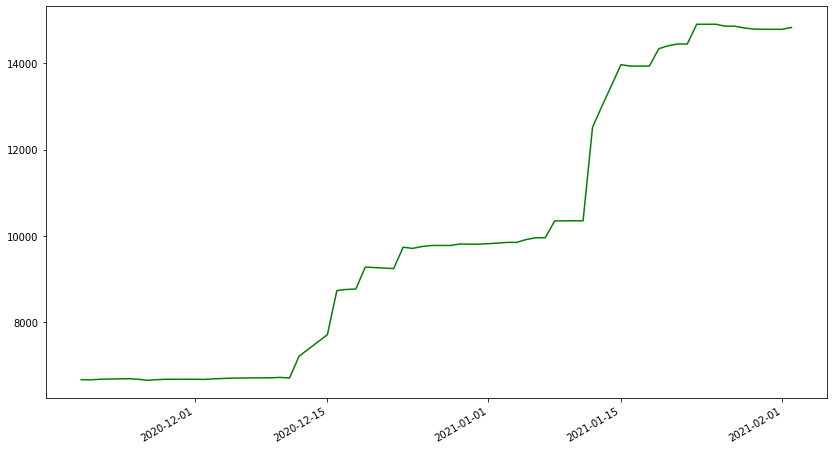

          Date     Value
33  2020-11-19   6676.27
34  2020-11-20   6670.78
35  2020-11-21   6686.48
36  2020-11-24   6697.89
37  2020-11-25   6685.71
..         ...       ...
28  2021-01-29  14793.35
29  2021-01-30  14786.76
30  2021-01-31  14786.76
31  2021-02-01  14786.76
32  2021-02-02  14829.25

[66 rows x 2 columns]


In [13]:
grouped_mf_data = mf_data.groupby('Date',as_index=False).agg({'Return':[np.sum]})
#Renaming the columns
grouped_mf_data.columns = ['Date','Value']

#Create a new date column to sort the data
grouped_mf_data['Modified_Date']=grouped_mf_data['Date'].apply(lambda x : datetime.strptime(x, '%m/%d/%Y'))
grouped_mf_data.sort_values(by=['Modified_Date'], inplace=True, ascending=True)

#Create the sting equivalent of the date olum
grouped_mf_data['Date_Modified_Str']=grouped_mf_data['Date'].apply(lambda x : datetime.strptime(x, '%m/%d/%Y').strftime("%Y-%m-%d"))

#Drop the extra columns and rename
grouped_mf_data = grouped_mf_data.drop(['Date','Modified_Date'],axis=1)
grouped_mf_data.columns = ['Value','Date']
grouped_mf_data = grouped_mf_data[['Date','Value']]

#Function to determine the color

def get_line_color(values):
    if(values[-1][1]>values[-2][1]):
        return 'green'
    return 'red'

#Show graph - Method 2
fig, ax = pyplot.subplots()
grouped_mf_data['Actual_Date']=grouped_mf_data['Date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
ax.plot(grouped_mf_data['Actual_Date'],grouped_mf_data['Value'], color=get_line_color(grouped_mf_data.values.tolist()))
ax.xaxis_date()     # interpret the x-axis values as dates
fig.set_size_inches(14, 8, forward=True)
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
pyplot.show()

grouped_mf_data = grouped_mf_data.drop(['Actual_Date'],axis=1)

print(grouped_mf_data)

## Transforming the Data Set to make it suitale for the LSTM Model

### Dropping the date column for Time Series Transformation

In [14]:
grouped_mf_data = grouped_mf_data.drop(['Date'],axis=1)

## Converting Time Series to Stationary

The given dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an modulating (changing) trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by **differencing the data**. That is the **observation from the previous time step (t-1) is subtracted from the current observation (t).** This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically **using the diff() function in pandas.**
Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.

We also need to **invert this process in order to take forecasts made on the differenced series back into their original scale.**

The function below, called **inverse_difference(), inverts this operation.**

In [31]:
# create a differenced series
def difference(supervised_converted_data, interval=1):
    data_diiference = list()
    for i in range(interval, len(supervised_converted_data)):
        value = supervised_converted_data[i][0] - supervised_converted_data[i - interval][0]
        data_diiference.append(value)
    return pd.Series(data_diiference)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


## Transforming the data to a supervised learning problem

The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here”.

In [29]:
def timeseries_to_supervised(grouped_data_values, lag=1):
    grouped_data = pd.DataFrame(grouped_data_values)
    columns = [grouped_data.shift(i) for i in range(1, lag+1)]
    columns.append(grouped_data)
    supervised_converted_data = pd.concat(columns, axis=1)
    supervised_converted_data.fillna(0, inplace=True)
    return supervised_converted_data

### Splitting the data into train and test

Cannot use test_train_split from sckit-learn for the following reasons -

1. The input is list of values (1-D) and not dataset
2. There is no X and Y parameters based on this kind of classification
3. Only values selected based on differential data value (1-D)

The solution is -

1. The ratio of split is 70-30
2. Based on the ratio split the value

In [47]:
def get_percentage(percent, whole):
  return (percent * whole) // 100

# Splitting the data into test and train for calculating accuracy
def get_train_test_data(list_of_values, percentage_of_split=70):
    seperator_value = get_percentage(percentage_of_split,len(list_of_values))
    return list_of_values[:seperator_value],list_of_values[seperator_value:]

    
#Running the above steps

#Get the values
grouped_values = grouped_mf_data.values

#Conver to linear series
linear_values = difference(grouped_values,1)

#transform to supervised learning
supervised_data = timeseries_to_supervised(linear_values,1)
supervised_values = supervised_data.values

#split into train and test data
train_data, test_data = get_train_test_data(supervised_values,70)

print(train_data)
print(test_data)

[[ 0.00000e+00 -5.49000e+00]
 [-5.49000e+00  1.57000e+01]
 [ 1.57000e+01  1.14100e+01]
 [ 1.14100e+01 -1.21800e+01]
 [-1.21800e+01 -2.58400e+01]
 [-2.58400e+01  1.62400e+01]
 [ 1.62400e+01  8.49000e+00]
 [ 8.49000e+00  1.90000e-01]
 [ 1.90000e-01 -4.10000e+00]
 [-4.10000e+00  1.33300e+01]
 [ 1.33300e+01  9.69000e+00]
 [ 9.69000e+00  7.61000e+00]
 [ 7.61000e+00  6.70000e+00]
 [ 6.70000e+00  0.00000e+00]
 [ 0.00000e+00  9.68000e+00]
 [ 9.68000e+00 -1.38400e+01]
 [-1.38400e+01  5.03130e+02]
 [ 5.03130e+02  5.00640e+02]
 [ 5.00640e+02  1.02157e+03]
 [ 1.02157e+03  2.50000e+01]
 [ 2.50000e+01  9.12000e+00]
 [ 9.12000e+00  5.08490e+02]
 [ 5.08490e+02 -3.42900e+01]
 [-3.42900e+01  4.94590e+02]
 [ 4.94590e+02 -2.74000e+01]
 [-2.74000e+01  4.36300e+01]
 [ 4.36300e+01  2.38800e+01]
 [ 2.38800e+01  0.00000e+00]
 [ 0.00000e+00  0.00000e+00]
 [ 0.00000e+00  3.43300e+01]
 [ 3.43300e+01 -4.39000e+00]
 [-4.39000e+00  0.00000e+00]
 [ 0.00000e+00  1.17100e+01]
 [ 1.17100e+01  1.40000e+01]
 [ 1.40000e+01

### Transform Time Series to Scale

Like other neural networks, **LSTMs expect data to be within the scale of the activation function used by the network.**

The default activation function for LSTMs is the **hyperbolic tangent (tanh), which outputs values between -1 and 1.** This is the preferred range for the time series data.

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

In [54]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train_data, test_data)

print(train_scaled)

[[-0.9688216  -0.97381342]
 [-0.97381342 -0.95454628]
 [-0.95454628 -0.95844699]
 [-0.95844699 -0.97989634]
 [-0.97989634 -0.99231678]
 [-0.99231678 -0.95405528]
 [-0.95405528 -0.96110202]
 [-0.96110202 -0.96864885]
 [-0.96864885 -0.97254955]
 [-0.97254955 -0.95670122]
 [-0.95670122 -0.96001091]
 [-0.96001091 -0.96190216]
 [-0.96190216 -0.96272959]
 [-0.96272959 -0.9688216 ]
 [-0.9688216  -0.96002   ]
 [-0.96002    -0.98140571]
 [-0.98140571 -0.51134752]
 [-0.51134752 -0.51361157]
 [-0.51361157 -0.03995272]
 [-0.03995272 -0.9460902 ]
 [-0.9460902  -0.96052919]
 [-0.96052919 -0.5064739 ]
 [-0.5064739  -1.        ]
 [-1.         -0.51911257]
 [-0.51911257 -0.99373522]
 [-0.99373522 -0.92915075]
 [-0.92915075 -0.94710857]
 [-0.94710857 -0.9688216 ]
 [-0.9688216  -0.9688216 ]
 [-0.9688216  -0.93760684]
 [-0.93760684 -0.97281324]
 [-0.97281324 -0.9688216 ]
 [-0.9688216  -0.95817421]
 [-0.95817421 -0.95609202]
 [-0.95609202 -0.95419167]
 [-0.95419167 -0.9688216 ]
 [-0.9688216  -0.90866521]
 

### Fitting the LTSM Model

The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.

The batch size is often much smaller than the total number of samples. It, along with the number of epochs, defines how quickly the network learns the data (how often the weights are updated).

The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.

The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer via the “batch_input_shape” argument.

The network requires a single neuron in the output layer with a linear activation to predict the number of data at the next time step.

Once the network is specified, it must be compiled into an efficient symbolic representation using a backend mathematical library, such as TensorFlow or Theano.

In compiling the network, we must specify a loss function and optimization algorithm. We will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, and the efficient ADAM optimization algorithm.

In [51]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [52]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.897668  ],
       [-0.97105277],
       [-1.0338275 ],
       [-1.0471455 ],
       [-1.0387571 ],
       [-1.0260862 ],
       [-1.0050303 ],
       [-0.97993517],
       [-0.9604075 ],
       [-0.9431089 ],
       [-0.92256594],
       [-0.90421283],
       [-0.8886678 ],
       [-0.87441874],
       [-0.862623  ],
       [-0.8482915 ],
       [-0.84109175],
       [-0.5824872 ],
       [-0.39759633],
       [-0.8585756 ],
       [-0.60163164],
       [-0.6684649 ],
       [-0.9461566 ],
       [-0.7595047 ],
       [-0.9822495 ],
       [-0.85425746],
       [-0.9345355 ],
       [-0.9611199 ],
       [-0.99461365],
       [-1.0123724 ],
       [-1.011713  ],
       [-0.9990579 ],
       [-0.99347293],
       [-0.9825088 ],
       [-0.9682952 ],
       [-0.95385134],
       [-0.94274306],
       [-0.91891587],
       [-0.88560784],
       [-0.8620995 ],
       [-0.7063273 ],
       [-0.5332873 ],
       [-0.47617024],
       [-0.48539108],
       [-0.41166145]], dtype=flo

In [73]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(grouped_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = grouped_values[len(train_data) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=13055.619315, Expected=13487.000000
Month=2, Predicted=13494.649094, Expected=13967.810000
Month=3, Predicted=13939.653681, Expected=13935.640000
Month=4, Predicted=14034.549228, Expected=13935.640000
Month=5, Predicted=13936.286703, Expected=13935.640000
Month=6, Predicted=13903.859769, Expected=14338.680000
Month=7, Predicted=14290.677977, Expected=14407.180000
Month=8, Predicted=14473.064056, Expected=14447.860000
Month=9, Predicted=14524.420310, Expected=14444.750000
Month=10, Predicted=14541.214880, Expected=14903.770000
Month=11, Predicted=15135.374351, Expected=14903.770000
Month=12, Predicted=15346.697771, Expected=14903.770000
Month=13, Predicted=15387.504959, Expected=14859.560000
Month=14, Predicted=15375.024865, Expected=14859.650000
Month=15, Predicted=15338.728913, Expected=14819.300000
Month=16, Predicted=15299.795779, Expected=14793.350000
Month=17, Predicted=15242.064545, Expected=14786.760000
Month=18, Predicted=15197.610499, Expected=14786.760000
M

### Performance Analysis

A line plot of the test data (blue) vs the predicted values (orange) is also created, providing context for the model skill.

Test RMSE: 367.091


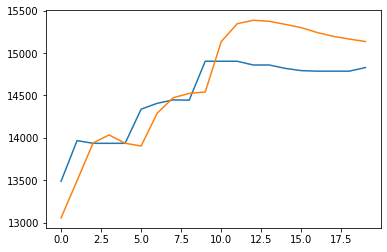

In [74]:
# report performance
seperator_value = get_percentage(70,len(grouped_values))
y_true = grouped_values[seperator_value:]

rmse = sqrt(mean_squared_error(y_true, predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
pyplot.plot(y_true)
pyplot.plot(predictions)
pyplot.show()